# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

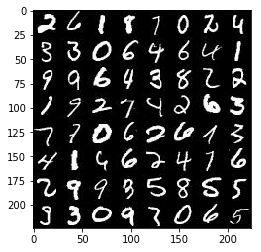

In [2]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

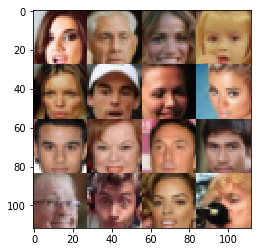

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # create the placeholder for real_inputs. First dimension in tuple = 'None', which is confusing, but means
    # we can have ANY number of instances in the batch
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='inputs_real')
    
    # create the placeholder for the z inputs. These will be used by the generator to generate images
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    
    # create the learning rate.
    learn_rate = tf.placeholder(tf.float32, (None), name="learning_rate")
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # set my alpha value for the leaky relu - using the same as the Udacity DCGAN walkthrough
    alpha = 0.2
    # reviewer comment - try using dropout in discriminator with low rate of dropping
    # reviewer comment - try using xavier initialisation. NOTE for the discriminator, the only one that
    # is a fully connected layer is the first one, so this is the only one to initialise.
    dropout_rate = 0.95
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input layer is 28*28*3 for the celebs, 28*28*1 for the MNIST
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # don't apply the batch normalisation to the input layer
        relu1 = tf.maximum(alpha * x1, x1) # leaky relu
        dropped1 = tf.nn.dropout(relu1, keep_prob=dropout_rate)
        # layer is now 14 * 14 * 64 (i.e. convoluted stack of 'images' of 14*14 across 64 filters)
        
        x2 = tf.layers.conv2d(dropped1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dropped2 = tf.nn.dropout(relu2, keep_prob=dropout_rate)
#         print('relu2.shape is {}'.format(relu2.shape))
        # layer is now 7 * 7 * 128
        
        x3 = tf.layers.conv2d(dropped2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # NOT used dropping at this layer, following reviewer comment - don't use it on last conv layer.
        print('relu3.shape is {}'.format(relu3.shape))
        # layer is now 4*4* 256 (or maybe 3*3? * 256)
        
        # Flatten this final tensor
        flat = tf.reshape(relu3, (-1, 4*4*256)) # will find out here if my dimension calcs are correct
        print('flat.shape is {}'.format(flat.shape))
        logits = tf.layers.dense(flat, 1) # output to one because it is a simple yes/no as to whether it is a "True" pic
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # set my alpha level for the leaky relus - using the same as the Udacity DCGAN walk-through
    alpha = 0.2
    
    # reviewer comment - try using xavier intialisation for the weights. For the generator there are several
    # fully connected layers - use it for each?
    # reviwer3 comment - DON'T save the xavier_weights as a variable and then apply it to each, as it will use 
    # the same weights in each, thus losing all stochastic behaviour
    
    # reviewer3 comment - use dropout as per discriminator
    dropout_rate = 0.95
    
    with tf.variable_scope("generator", reuse=not is_train):
        # this threw me for AGES - see Slack channel. You want to set reuse to True when is_training is False and
        # vice versa. When you are training you don't re-use the variables.
        
        # Reviewer suggestion - use 3 layers (previously had 2) - suggests 512, 256, 128 to output.
        
        # create first, fully connected layer
        x1_dense = tf.layers.dense(z, 7*7*512) # match the discriminator - work backwards
        
        # reshape it into a convolutional tensor and start the convolutional stack.
        x1 = tf.reshape(x1_dense, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training= is_train)
        relu1 = tf.maximum(alpha * bn1, bn1) # leaky relu
        #print("relu1.shape is {}".format(relu1.shape))
        dropped1 = tf.nn.dropout(relu1, keep_prob=dropout_rate)
        # layer is 7 * 7 * 512
        
        x2 = tf.layers.conv2d_transpose(dropped1, 256, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print("relu2.shape is {}".format(relu2.shape))
        dropped2 = tf.nn.dropout(relu2, keep_prob=dropout_rate)
        # layer is now 14 * 14 * 256
        
        x3 = tf.layers.conv2d_transpose(dropped2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
#         print("relu3.shape is {}".format(relu3.shape))
        dropped3 = tf.nn.dropout(relu3, keep_prob=dropout_rate)
        # layer is now 28 * 28  * 128
        
        # create the output layer
        logits = tf.layers.conv2d_transpose(dropped3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # this is how we solve for the different RGB channel dimension diffs between the MNIST and celeba
        # as the number of 'filters' is now the number of channels. Same thing.
        # Note we need to set the strides at 1, as the image shape is already 28 * 28 and we don't want to increase
        # it to 56*56.
        # layer is now 28 * 28 * 3 or 28 * 28 * 1
        #print('logits has shape: {}'.format(logits.shape))
        
        out = tf.tanh(logits)
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # reviewer #2 comment - try using smoothing on discriminator labels to improve performance
    smooth =0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # reviewer comment - to try to prevent the discriminator from being too strong, only the discriminator labels
    # (one-sided) are reduced from 1 to 0.9. This is known as label smoothing.
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels = tf.ones_like(d_model_real) * (1-smooth))
    )
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels = tf.zeros_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    # NOTE - only the discriminator labels are smoothed, not the generator labels
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    ) 
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tvars = tf.trainable_variables()
    
    d_vars = [var for var in tvars if var.name.startswith('discriminator')]
    #print(d_vars)
    g_vars = [var for var in tvars if var.name.startswith('generator')]
    #print(g_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt= tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt= tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     saver = tf.train.Saver()
    
    # create the inputs placeholders etc using the model_inputs function
    # see playground cell below to see how I found out the dimensions
    inputs_real, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # create the losses using the model_loss function
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    
    # optimize those losses using the model_opt() function
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate=learning_rate, beta1=beta1)

    losses = []
    # note - I have the losses in a list, but I don't actually return them at the end. This is because I don't
    # want to mess around with the Udacity cells when the code is run to generate figures etc. It's for future
    # projects, to remind me to store the losses to create graphs of training loss vs epochs
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                
                # TODO: Train Model
                # from Slack channel - the batch_images have data in range -0.5 to +0.5, so double them to get the image
                batch_images = batch_images *2
                
                
                # create random noise z_inputs to seed the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,
                                                   inputs_z: batch_z,
                                                   learn_rate: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images,
                                                    inputs_z: batch_z,
                                                    learn_rate: learning_rate
                    
                })
                
                # calculate loss every 25 batches?
                if steps % 25 == 0:
                    train_loss_d = d_loss.eval(feed_dict={
                        inputs_real: batch_images,
                        inputs_z: batch_z
                    })
                    train_loss_g = g_loss.eval(feed_dict={
                        inputs_z: batch_z
                    })
                    print('Epoch: {}'.format(epoch_i + 1), end=", ")
                    print('Batch: {}'.format(steps), end=": ")
                    print('Discr train loss: {:.3f}'.format(train_loss_d), end=", ")
                    print('Gen train loss: {:.3f}'.format(train_loss_g))
                    
                    # save losses to view after training:
                    losses.append((train_loss_d, train_loss_g))
                
                # show the images created every 100 batches?
                if steps % 100 == 0:
                    # as per instructions, run the show_generator_output every 100 batches
                    show_generator_output(sess, n_images=36, input_z=inputs_z, out_channel_dim=data_shape[3],
                                         image_mode=data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')
                

In [16]:
# DCFW created playground cell to find out attributes etc.
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print (mnist_dataset.shape) # finding the dimensions - need this for the inputs

(60000, 28, 28, 1)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

following comments from reviewer, looked at [Radford paper](https://arxiv.org/abs/1511.06434) for hyperparameter suggestions.

relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Epoch: 1, Batch: 25: Discr train loss: 0.400, Gen train loss: 4.162
Epoch: 1, Batch: 50: Discr train loss: 1.534, Gen train loss: 0.419
Epoch: 1, Batch: 75: Discr train loss: 1.753, Gen train loss: 1.162
Epoch: 1, Batch: 100: Discr train loss: 2.022, Gen train loss: 0.292


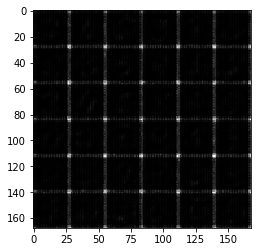

Epoch: 1, Batch: 125: Discr train loss: 1.322, Gen train loss: 0.835
Epoch: 1, Batch: 150: Discr train loss: 1.559, Gen train loss: 0.489
Epoch: 1, Batch: 175: Discr train loss: 1.244, Gen train loss: 0.715
Epoch: 1, Batch: 200: Discr train loss: 1.278, Gen train loss: 0.870


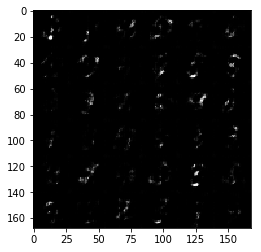

Epoch: 1, Batch: 225: Discr train loss: 1.214, Gen train loss: 0.807
Epoch: 1, Batch: 250: Discr train loss: 1.330, Gen train loss: 0.624
Epoch: 1, Batch: 275: Discr train loss: 1.207, Gen train loss: 1.045
Epoch: 1, Batch: 300: Discr train loss: 1.227, Gen train loss: 1.605


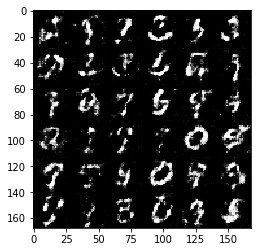

Epoch: 1, Batch: 325: Discr train loss: 1.021, Gen train loss: 1.589
Epoch: 1, Batch: 350: Discr train loss: 1.516, Gen train loss: 0.498
Epoch: 1, Batch: 375: Discr train loss: 1.458, Gen train loss: 0.492
Epoch: 1, Batch: 400: Discr train loss: 1.170, Gen train loss: 1.535


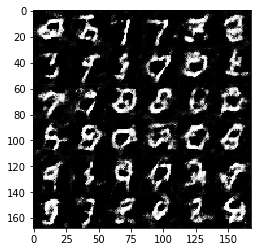

Epoch: 1, Batch: 425: Discr train loss: 1.384, Gen train loss: 0.535
Epoch: 1, Batch: 450: Discr train loss: 1.334, Gen train loss: 0.628
Epoch: 1, Batch: 475: Discr train loss: 1.311, Gen train loss: 1.013
Epoch: 1, Batch: 500: Discr train loss: 1.211, Gen train loss: 0.638


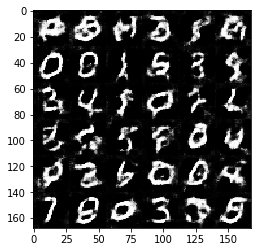

Epoch: 1, Batch: 525: Discr train loss: 1.256, Gen train loss: 0.614
Epoch: 1, Batch: 550: Discr train loss: 1.281, Gen train loss: 0.583
Epoch: 1, Batch: 575: Discr train loss: 1.445, Gen train loss: 0.479
Epoch: 1, Batch: 600: Discr train loss: 1.245, Gen train loss: 0.858


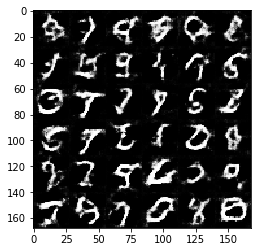

Epoch: 1, Batch: 625: Discr train loss: 1.202, Gen train loss: 1.109
Epoch: 1, Batch: 650: Discr train loss: 1.101, Gen train loss: 1.006
Epoch: 1, Batch: 675: Discr train loss: 1.275, Gen train loss: 0.583
Epoch: 1, Batch: 700: Discr train loss: 1.203, Gen train loss: 0.922


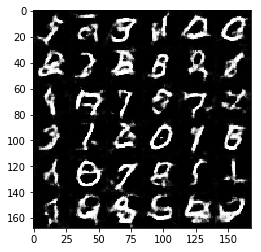

Epoch: 1, Batch: 725: Discr train loss: 1.483, Gen train loss: 0.487
Epoch: 1, Batch: 750: Discr train loss: 1.129, Gen train loss: 0.901
Epoch: 1, Batch: 775: Discr train loss: 1.151, Gen train loss: 1.134
Epoch: 1, Batch: 800: Discr train loss: 1.134, Gen train loss: 0.985


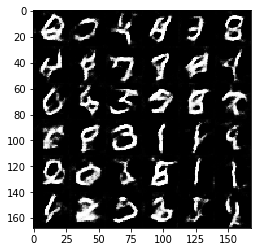

Epoch: 1, Batch: 825: Discr train loss: 1.067, Gen train loss: 0.939
Epoch: 1, Batch: 850: Discr train loss: 1.204, Gen train loss: 1.469
Epoch: 1, Batch: 875: Discr train loss: 1.218, Gen train loss: 0.783
Epoch: 1, Batch: 900: Discr train loss: 1.142, Gen train loss: 0.838


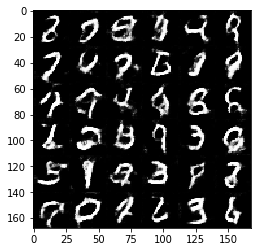

Epoch: 1, Batch: 925: Discr train loss: 1.299, Gen train loss: 0.659
Epoch: 1, Batch: 950: Discr train loss: 1.203, Gen train loss: 0.635
Epoch: 1, Batch: 975: Discr train loss: 1.172, Gen train loss: 1.112
Epoch: 1, Batch: 1000: Discr train loss: 1.160, Gen train loss: 1.245


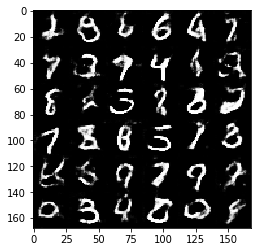

Epoch: 1, Batch: 1025: Discr train loss: 1.101, Gen train loss: 0.847
Epoch: 1, Batch: 1050: Discr train loss: 1.111, Gen train loss: 0.772
Epoch: 1, Batch: 1075: Discr train loss: 1.209, Gen train loss: 0.648
Epoch: 1, Batch: 1100: Discr train loss: 1.157, Gen train loss: 1.530


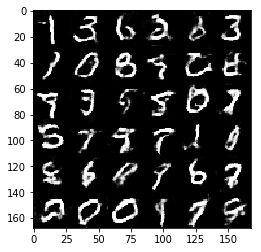

Epoch: 1, Batch: 1125: Discr train loss: 1.048, Gen train loss: 0.982
Epoch: 1, Batch: 1150: Discr train loss: 1.187, Gen train loss: 1.008
Epoch: 1, Batch: 1175: Discr train loss: 1.113, Gen train loss: 1.284
Epoch: 1, Batch: 1200: Discr train loss: 1.114, Gen train loss: 0.825


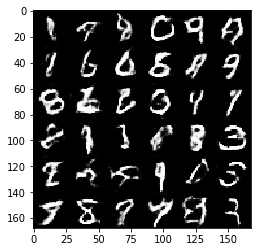

Epoch: 1, Batch: 1225: Discr train loss: 1.170, Gen train loss: 1.007
Epoch: 1, Batch: 1250: Discr train loss: 1.463, Gen train loss: 0.457
Epoch: 1, Batch: 1275: Discr train loss: 1.198, Gen train loss: 0.755
Epoch: 1, Batch: 1300: Discr train loss: 1.515, Gen train loss: 0.525


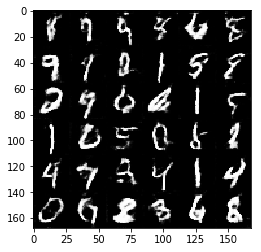

Epoch: 1, Batch: 1325: Discr train loss: 1.269, Gen train loss: 0.705
Epoch: 1, Batch: 1350: Discr train loss: 1.043, Gen train loss: 1.269
Epoch: 1, Batch: 1375: Discr train loss: 1.068, Gen train loss: 1.193
Epoch: 1, Batch: 1400: Discr train loss: 1.223, Gen train loss: 1.489


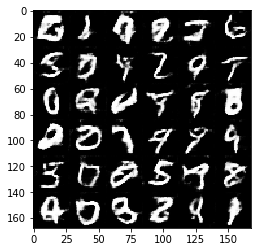

Epoch: 1, Batch: 1425: Discr train loss: 1.451, Gen train loss: 0.508
Epoch: 1, Batch: 1450: Discr train loss: 1.014, Gen train loss: 1.201
Epoch: 1, Batch: 1475: Discr train loss: 1.252, Gen train loss: 0.709
Epoch: 1, Batch: 1500: Discr train loss: 1.041, Gen train loss: 1.033


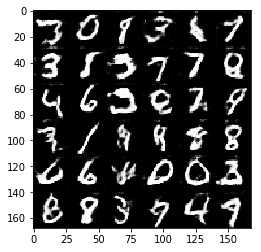

Epoch: 1, Batch: 1525: Discr train loss: 1.113, Gen train loss: 1.734
Epoch: 1, Batch: 1550: Discr train loss: 1.167, Gen train loss: 0.658
Epoch: 1, Batch: 1575: Discr train loss: 2.079, Gen train loss: 0.251
Epoch: 1, Batch: 1600: Discr train loss: 1.104, Gen train loss: 0.912


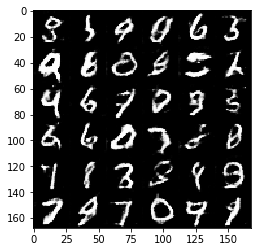

Epoch: 1, Batch: 1625: Discr train loss: 1.323, Gen train loss: 0.605
Epoch: 1, Batch: 1650: Discr train loss: 1.107, Gen train loss: 0.688
Epoch: 1, Batch: 1675: Discr train loss: 1.020, Gen train loss: 0.945
Epoch: 1, Batch: 1700: Discr train loss: 1.242, Gen train loss: 1.275


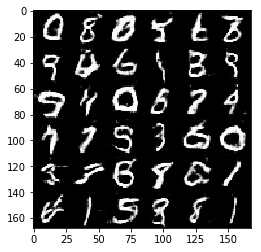

Epoch: 1, Batch: 1725: Discr train loss: 1.260, Gen train loss: 0.664
Epoch: 1, Batch: 1750: Discr train loss: 1.138, Gen train loss: 0.802
Epoch: 1, Batch: 1775: Discr train loss: 1.011, Gen train loss: 1.085
Epoch: 1, Batch: 1800: Discr train loss: 0.797, Gen train loss: 1.318


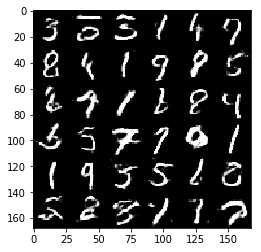

Epoch: 1, Batch: 1825: Discr train loss: 1.056, Gen train loss: 1.320
Epoch: 1, Batch: 1850: Discr train loss: 0.964, Gen train loss: 0.844
Epoch: 1, Batch: 1875: Discr train loss: 1.007, Gen train loss: 0.993
Epoch: 2, Batch: 1900: Discr train loss: 0.940, Gen train loss: 1.155


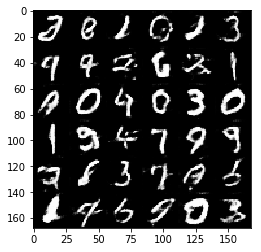

Epoch: 2, Batch: 1925: Discr train loss: 1.811, Gen train loss: 0.396
Epoch: 2, Batch: 1950: Discr train loss: 0.987, Gen train loss: 1.125
Epoch: 2, Batch: 1975: Discr train loss: 0.880, Gen train loss: 1.167
Epoch: 2, Batch: 2000: Discr train loss: 0.969, Gen train loss: 1.753


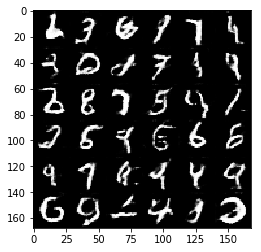

Epoch: 2, Batch: 2025: Discr train loss: 0.751, Gen train loss: 1.441
Epoch: 2, Batch: 2050: Discr train loss: 1.100, Gen train loss: 0.797
Epoch: 2, Batch: 2075: Discr train loss: 0.786, Gen train loss: 1.515
Epoch: 2, Batch: 2100: Discr train loss: 0.788, Gen train loss: 1.244


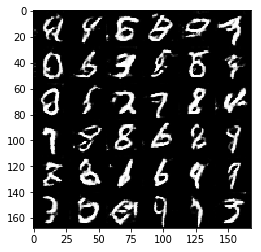

Epoch: 2, Batch: 2125: Discr train loss: 1.073, Gen train loss: 0.713
Epoch: 2, Batch: 2150: Discr train loss: 1.444, Gen train loss: 0.489
Epoch: 2, Batch: 2175: Discr train loss: 1.060, Gen train loss: 0.945
Epoch: 2, Batch: 2200: Discr train loss: 0.876, Gen train loss: 1.366


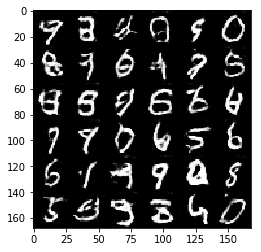

Epoch: 2, Batch: 2225: Discr train loss: 1.075, Gen train loss: 0.840
Epoch: 2, Batch: 2250: Discr train loss: 1.118, Gen train loss: 0.663
Epoch: 2, Batch: 2275: Discr train loss: 0.867, Gen train loss: 0.994
Epoch: 2, Batch: 2300: Discr train loss: 1.086, Gen train loss: 1.201


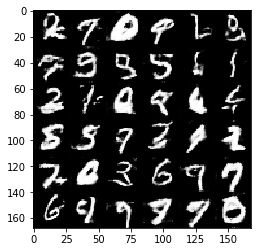

Epoch: 2, Batch: 2325: Discr train loss: 0.958, Gen train loss: 0.983
Epoch: 2, Batch: 2350: Discr train loss: 1.094, Gen train loss: 0.791
Epoch: 2, Batch: 2375: Discr train loss: 1.178, Gen train loss: 0.693
Epoch: 2, Batch: 2400: Discr train loss: 1.324, Gen train loss: 0.600


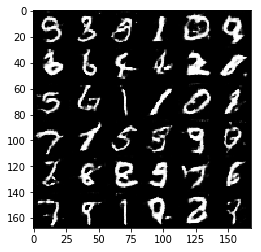

Epoch: 2, Batch: 2425: Discr train loss: 1.063, Gen train loss: 1.890
Epoch: 2, Batch: 2450: Discr train loss: 0.723, Gen train loss: 1.360
Epoch: 2, Batch: 2475: Discr train loss: 1.469, Gen train loss: 0.473
Epoch: 2, Batch: 2500: Discr train loss: 0.845, Gen train loss: 1.292


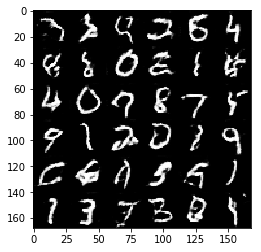

Epoch: 2, Batch: 2525: Discr train loss: 1.021, Gen train loss: 1.205
Epoch: 2, Batch: 2550: Discr train loss: 0.877, Gen train loss: 1.227
Epoch: 2, Batch: 2575: Discr train loss: 1.099, Gen train loss: 0.941
Epoch: 2, Batch: 2600: Discr train loss: 1.265, Gen train loss: 0.755


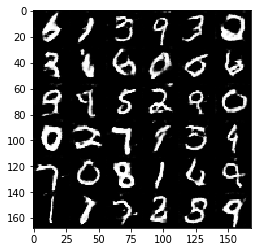

Epoch: 2, Batch: 2625: Discr train loss: 0.784, Gen train loss: 1.325
Epoch: 2, Batch: 2650: Discr train loss: 1.066, Gen train loss: 0.910
Epoch: 2, Batch: 2675: Discr train loss: 0.820, Gen train loss: 1.401
Epoch: 2, Batch: 2700: Discr train loss: 0.687, Gen train loss: 1.951


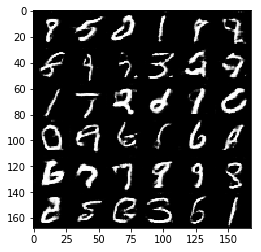

Epoch: 2, Batch: 2725: Discr train loss: 0.822, Gen train loss: 1.831
Epoch: 2, Batch: 2750: Discr train loss: 0.795, Gen train loss: 1.246
Epoch: 2, Batch: 2775: Discr train loss: 0.930, Gen train loss: 0.924
Epoch: 2, Batch: 2800: Discr train loss: 0.896, Gen train loss: 1.667


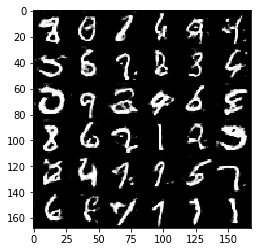

Epoch: 2, Batch: 2825: Discr train loss: 0.679, Gen train loss: 1.923
Epoch: 2, Batch: 2850: Discr train loss: 0.732, Gen train loss: 1.652
Epoch: 2, Batch: 2875: Discr train loss: 1.180, Gen train loss: 0.702
Epoch: 2, Batch: 2900: Discr train loss: 1.028, Gen train loss: 0.832


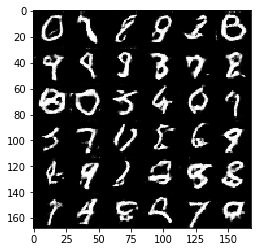

Epoch: 2, Batch: 2925: Discr train loss: 1.037, Gen train loss: 0.915
Epoch: 2, Batch: 2950: Discr train loss: 0.759, Gen train loss: 1.771
Epoch: 2, Batch: 2975: Discr train loss: 0.671, Gen train loss: 1.548
Epoch: 2, Batch: 3000: Discr train loss: 1.272, Gen train loss: 0.742


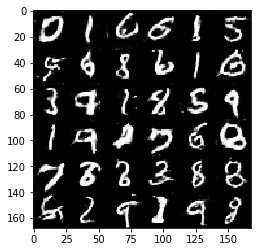

Epoch: 2, Batch: 3025: Discr train loss: 0.772, Gen train loss: 1.587
Epoch: 2, Batch: 3050: Discr train loss: 0.751, Gen train loss: 2.027
Epoch: 2, Batch: 3075: Discr train loss: 1.205, Gen train loss: 0.841
Epoch: 2, Batch: 3100: Discr train loss: 1.128, Gen train loss: 0.697


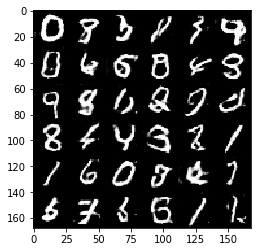

Epoch: 2, Batch: 3125: Discr train loss: 0.799, Gen train loss: 1.499
Epoch: 2, Batch: 3150: Discr train loss: 0.804, Gen train loss: 1.387
Epoch: 2, Batch: 3175: Discr train loss: 0.827, Gen train loss: 1.232
Epoch: 2, Batch: 3200: Discr train loss: 1.041, Gen train loss: 0.917


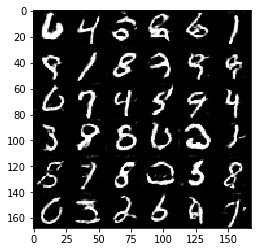

Epoch: 2, Batch: 3225: Discr train loss: 1.186, Gen train loss: 0.789
Epoch: 2, Batch: 3250: Discr train loss: 0.708, Gen train loss: 1.431
Epoch: 2, Batch: 3275: Discr train loss: 1.372, Gen train loss: 2.739
Epoch: 2, Batch: 3300: Discr train loss: 0.944, Gen train loss: 1.417


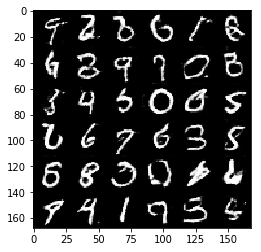

Epoch: 2, Batch: 3325: Discr train loss: 0.673, Gen train loss: 1.476
Epoch: 2, Batch: 3350: Discr train loss: 1.039, Gen train loss: 0.917
Epoch: 2, Batch: 3375: Discr train loss: 0.780, Gen train loss: 1.463
Epoch: 2, Batch: 3400: Discr train loss: 0.856, Gen train loss: 1.075


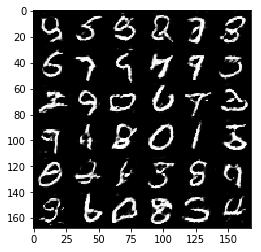

Epoch: 2, Batch: 3425: Discr train loss: 0.831, Gen train loss: 1.416
Epoch: 2, Batch: 3450: Discr train loss: 0.825, Gen train loss: 1.342
Epoch: 2, Batch: 3475: Discr train loss: 0.759, Gen train loss: 1.362
Epoch: 2, Batch: 3500: Discr train loss: 0.782, Gen train loss: 1.284


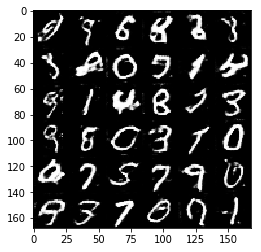

Epoch: 2, Batch: 3525: Discr train loss: 0.900, Gen train loss: 1.110
Epoch: 2, Batch: 3550: Discr train loss: 0.755, Gen train loss: 1.781
Epoch: 2, Batch: 3575: Discr train loss: 0.805, Gen train loss: 1.226
Epoch: 2, Batch: 3600: Discr train loss: 0.834, Gen train loss: 1.585


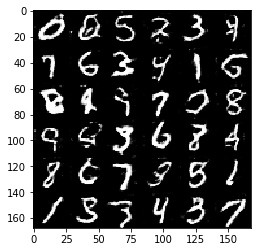

Epoch: 2, Batch: 3625: Discr train loss: 0.951, Gen train loss: 1.091
Epoch: 2, Batch: 3650: Discr train loss: 0.895, Gen train loss: 1.274
Epoch: 2, Batch: 3675: Discr train loss: 0.682, Gen train loss: 2.026
Epoch: 2, Batch: 3700: Discr train loss: 0.767, Gen train loss: 1.399


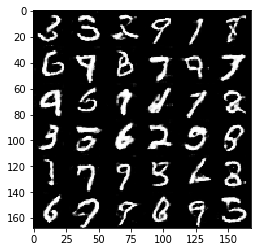

Epoch: 2, Batch: 3725: Discr train loss: 0.716, Gen train loss: 1.582
Epoch: 2, Batch: 3750: Discr train loss: 1.451, Gen train loss: 0.648


In [17]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Epoch: 1, Batch: 25: Discr train loss: 1.636, Gen train loss: 0.452
Epoch: 1, Batch: 50: Discr train loss: 0.957, Gen train loss: 1.986
Epoch: 1, Batch: 75: Discr train loss: 0.745, Gen train loss: 1.752
Epoch: 1, Batch: 100: Discr train loss: 0.829, Gen train loss: 1.175


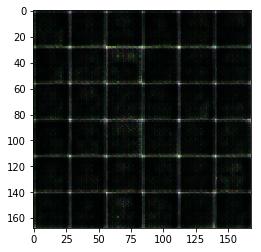

Epoch: 1, Batch: 125: Discr train loss: 0.478, Gen train loss: 2.857
Epoch: 1, Batch: 150: Discr train loss: 0.637, Gen train loss: 3.831
Epoch: 1, Batch: 175: Discr train loss: 0.544, Gen train loss: 2.177
Epoch: 1, Batch: 200: Discr train loss: 2.429, Gen train loss: 0.212


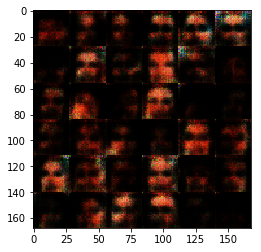

Epoch: 1, Batch: 225: Discr train loss: 0.648, Gen train loss: 3.395
Epoch: 1, Batch: 250: Discr train loss: 0.539, Gen train loss: 2.855
Epoch: 1, Batch: 275: Discr train loss: 1.321, Gen train loss: 0.612
Epoch: 1, Batch: 300: Discr train loss: 0.621, Gen train loss: 2.468


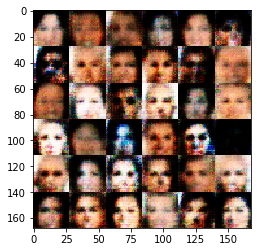

Epoch: 1, Batch: 325: Discr train loss: 0.754, Gen train loss: 1.900
Epoch: 1, Batch: 350: Discr train loss: 0.922, Gen train loss: 2.541
Epoch: 1, Batch: 375: Discr train loss: 0.827, Gen train loss: 1.428
Epoch: 1, Batch: 400: Discr train loss: 1.024, Gen train loss: 2.997


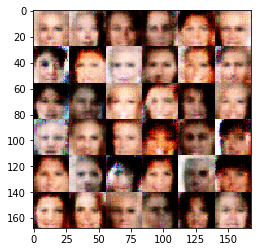

Epoch: 1, Batch: 425: Discr train loss: 1.406, Gen train loss: 0.586
Epoch: 1, Batch: 450: Discr train loss: 0.755, Gen train loss: 1.398
Epoch: 1, Batch: 475: Discr train loss: 1.383, Gen train loss: 0.704
Epoch: 1, Batch: 500: Discr train loss: 2.087, Gen train loss: 0.201


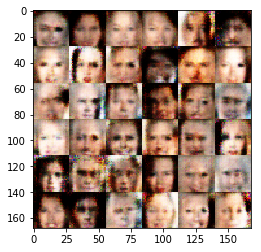

Epoch: 1, Batch: 525: Discr train loss: 0.857, Gen train loss: 1.313
Epoch: 1, Batch: 550: Discr train loss: 1.604, Gen train loss: 0.372
Epoch: 1, Batch: 575: Discr train loss: 1.882, Gen train loss: 2.932
Epoch: 1, Batch: 600: Discr train loss: 1.305, Gen train loss: 2.240


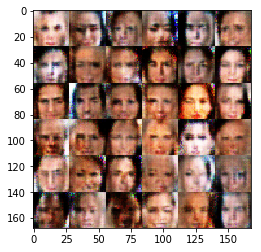

Epoch: 1, Batch: 625: Discr train loss: 1.333, Gen train loss: 2.897
Epoch: 1, Batch: 650: Discr train loss: 0.650, Gen train loss: 1.714
Epoch: 1, Batch: 675: Discr train loss: 1.008, Gen train loss: 0.976
Epoch: 1, Batch: 700: Discr train loss: 0.783, Gen train loss: 1.187


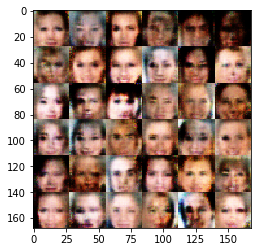

Epoch: 1, Batch: 725: Discr train loss: 0.896, Gen train loss: 1.888
Epoch: 1, Batch: 750: Discr train loss: 0.844, Gen train loss: 3.442
Epoch: 1, Batch: 775: Discr train loss: 1.140, Gen train loss: 1.475
Epoch: 1, Batch: 800: Discr train loss: 2.183, Gen train loss: 5.232


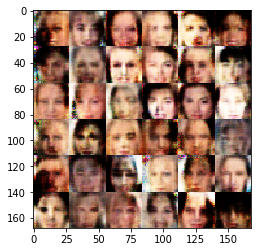

Epoch: 1, Batch: 825: Discr train loss: 1.386, Gen train loss: 0.463
Epoch: 1, Batch: 850: Discr train loss: 0.761, Gen train loss: 1.209
Epoch: 1, Batch: 875: Discr train loss: 2.825, Gen train loss: 3.333
Epoch: 1, Batch: 900: Discr train loss: 0.994, Gen train loss: 1.583


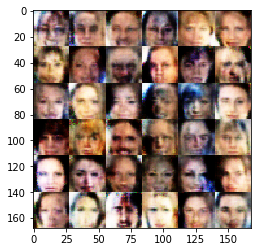

Epoch: 1, Batch: 925: Discr train loss: 1.616, Gen train loss: 0.327
Epoch: 1, Batch: 950: Discr train loss: 1.034, Gen train loss: 0.978
Epoch: 1, Batch: 975: Discr train loss: 0.670, Gen train loss: 2.241
Epoch: 1, Batch: 1000: Discr train loss: 0.652, Gen train loss: 1.852


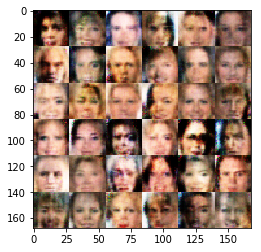

Epoch: 1, Batch: 1025: Discr train loss: 0.753, Gen train loss: 2.456
Epoch: 1, Batch: 1050: Discr train loss: 1.017, Gen train loss: 1.354
Epoch: 1, Batch: 1075: Discr train loss: 1.217, Gen train loss: 0.553
Epoch: 1, Batch: 1100: Discr train loss: 1.030, Gen train loss: 1.619


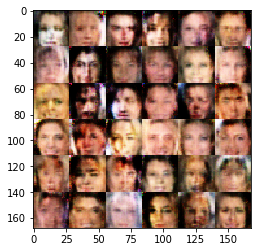

Epoch: 1, Batch: 1125: Discr train loss: 1.301, Gen train loss: 0.500
Epoch: 1, Batch: 1150: Discr train loss: 0.589, Gen train loss: 2.355
Epoch: 1, Batch: 1175: Discr train loss: 1.424, Gen train loss: 0.481
Epoch: 1, Batch: 1200: Discr train loss: 0.573, Gen train loss: 2.399


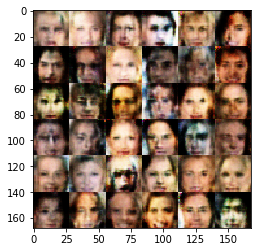

Epoch: 1, Batch: 1225: Discr train loss: 1.077, Gen train loss: 1.154
Epoch: 1, Batch: 1250: Discr train loss: 1.241, Gen train loss: 1.323
Epoch: 1, Batch: 1275: Discr train loss: 1.495, Gen train loss: 0.393
Epoch: 1, Batch: 1300: Discr train loss: 0.765, Gen train loss: 1.290


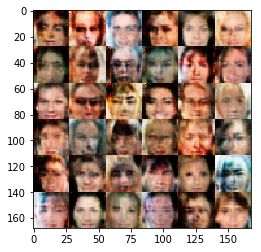

Epoch: 1, Batch: 1325: Discr train loss: 0.793, Gen train loss: 1.094
Epoch: 1, Batch: 1350: Discr train loss: 0.757, Gen train loss: 1.919
Epoch: 1, Batch: 1375: Discr train loss: 1.064, Gen train loss: 1.111
Epoch: 1, Batch: 1400: Discr train loss: 0.989, Gen train loss: 1.457


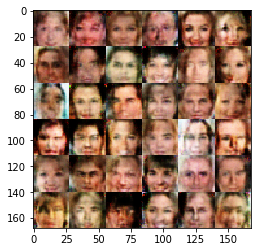

Epoch: 1, Batch: 1425: Discr train loss: 1.146, Gen train loss: 1.311
Epoch: 1, Batch: 1450: Discr train loss: 1.336, Gen train loss: 0.587
Epoch: 1, Batch: 1475: Discr train loss: 1.683, Gen train loss: 0.394
Epoch: 1, Batch: 1500: Discr train loss: 1.029, Gen train loss: 1.712


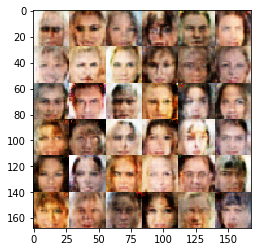

Epoch: 1, Batch: 1525: Discr train loss: 0.814, Gen train loss: 1.448
Epoch: 1, Batch: 1550: Discr train loss: 1.131, Gen train loss: 0.875
Epoch: 1, Batch: 1575: Discr train loss: 1.115, Gen train loss: 0.740
Epoch: 1, Batch: 1600: Discr train loss: 1.190, Gen train loss: 0.649


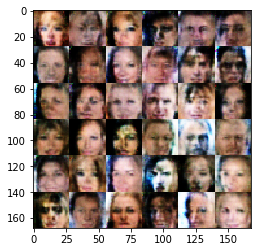

Epoch: 1, Batch: 1625: Discr train loss: 0.642, Gen train loss: 1.480
Epoch: 1, Batch: 1650: Discr train loss: 1.119, Gen train loss: 0.751
Epoch: 1, Batch: 1675: Discr train loss: 1.383, Gen train loss: 0.509
Epoch: 1, Batch: 1700: Discr train loss: 0.897, Gen train loss: 1.259


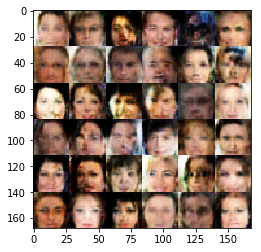

Epoch: 1, Batch: 1725: Discr train loss: 1.294, Gen train loss: 0.623
Epoch: 1, Batch: 1750: Discr train loss: 0.840, Gen train loss: 1.295
Epoch: 1, Batch: 1775: Discr train loss: 1.323, Gen train loss: 0.462
Epoch: 1, Batch: 1800: Discr train loss: 0.856, Gen train loss: 1.745


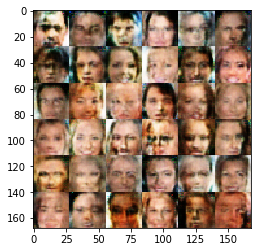

Epoch: 1, Batch: 1825: Discr train loss: 1.148, Gen train loss: 1.360
Epoch: 1, Batch: 1850: Discr train loss: 1.291, Gen train loss: 1.161
Epoch: 1, Batch: 1875: Discr train loss: 1.259, Gen train loss: 0.622
Epoch: 1, Batch: 1900: Discr train loss: 1.138, Gen train loss: 1.602


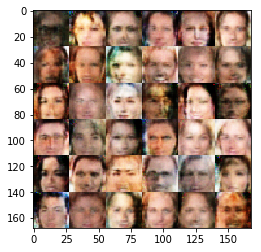

Epoch: 1, Batch: 1925: Discr train loss: 1.205, Gen train loss: 1.030
Epoch: 1, Batch: 1950: Discr train loss: 0.987, Gen train loss: 1.210
Epoch: 1, Batch: 1975: Discr train loss: 1.130, Gen train loss: 1.327
Epoch: 1, Batch: 2000: Discr train loss: 0.959, Gen train loss: 1.097


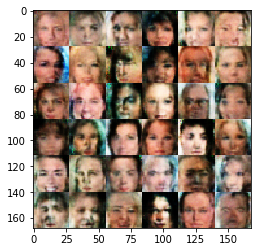

Epoch: 1, Batch: 2025: Discr train loss: 1.086, Gen train loss: 1.037
Epoch: 1, Batch: 2050: Discr train loss: 1.086, Gen train loss: 0.991
Epoch: 1, Batch: 2075: Discr train loss: 1.494, Gen train loss: 0.532
Epoch: 1, Batch: 2100: Discr train loss: 0.621, Gen train loss: 1.624


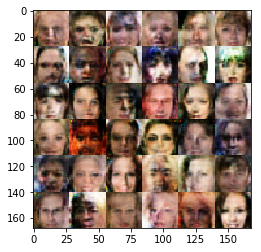

Epoch: 1, Batch: 2125: Discr train loss: 1.144, Gen train loss: 0.850
Epoch: 1, Batch: 2150: Discr train loss: 1.599, Gen train loss: 0.316
Epoch: 1, Batch: 2175: Discr train loss: 1.166, Gen train loss: 1.476
Epoch: 1, Batch: 2200: Discr train loss: 1.231, Gen train loss: 1.295


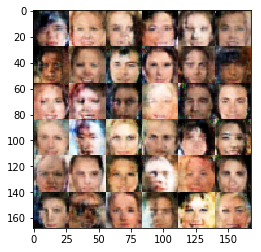

Epoch: 1, Batch: 2225: Discr train loss: 0.983, Gen train loss: 1.671
Epoch: 1, Batch: 2250: Discr train loss: 0.811, Gen train loss: 1.518
Epoch: 1, Batch: 2275: Discr train loss: 1.380, Gen train loss: 0.878
Epoch: 1, Batch: 2300: Discr train loss: 0.918, Gen train loss: 1.307


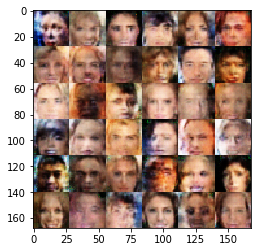

Epoch: 1, Batch: 2325: Discr train loss: 1.309, Gen train loss: 0.855
Epoch: 1, Batch: 2350: Discr train loss: 1.077, Gen train loss: 0.859
Epoch: 1, Batch: 2375: Discr train loss: 1.433, Gen train loss: 0.442
Epoch: 1, Batch: 2400: Discr train loss: 1.242, Gen train loss: 0.809


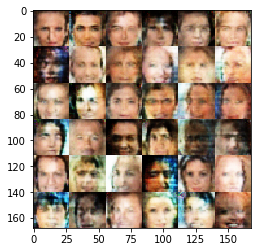

Epoch: 1, Batch: 2425: Discr train loss: 1.494, Gen train loss: 1.669
Epoch: 1, Batch: 2450: Discr train loss: 1.530, Gen train loss: 0.381
Epoch: 1, Batch: 2475: Discr train loss: 0.974, Gen train loss: 1.375
Epoch: 1, Batch: 2500: Discr train loss: 1.287, Gen train loss: 1.179


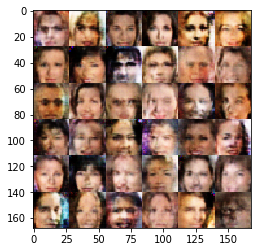

Epoch: 1, Batch: 2525: Discr train loss: 1.046, Gen train loss: 0.735
Epoch: 1, Batch: 2550: Discr train loss: 0.901, Gen train loss: 0.876
Epoch: 1, Batch: 2575: Discr train loss: 1.315, Gen train loss: 1.328
Epoch: 1, Batch: 2600: Discr train loss: 1.177, Gen train loss: 0.746


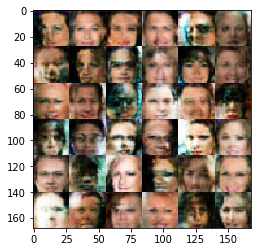

Epoch: 1, Batch: 2625: Discr train loss: 1.177, Gen train loss: 0.711
Epoch: 1, Batch: 2650: Discr train loss: 0.902, Gen train loss: 2.110
Epoch: 1, Batch: 2675: Discr train loss: 1.221, Gen train loss: 0.748
Epoch: 1, Batch: 2700: Discr train loss: 0.729, Gen train loss: 1.437


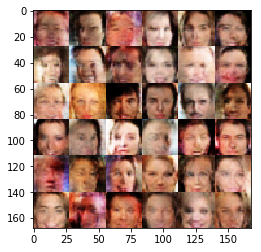

Epoch: 1, Batch: 2725: Discr train loss: 1.075, Gen train loss: 1.380
Epoch: 1, Batch: 2750: Discr train loss: 1.095, Gen train loss: 0.818
Epoch: 1, Batch: 2775: Discr train loss: 1.147, Gen train loss: 0.840
Epoch: 1, Batch: 2800: Discr train loss: 0.934, Gen train loss: 1.318


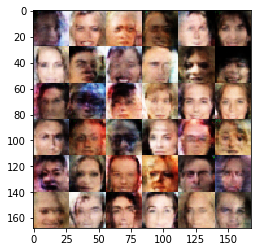

Epoch: 1, Batch: 2825: Discr train loss: 1.381, Gen train loss: 0.549
Epoch: 1, Batch: 2850: Discr train loss: 1.473, Gen train loss: 1.494
Epoch: 1, Batch: 2875: Discr train loss: 1.091, Gen train loss: 0.635
Epoch: 1, Batch: 2900: Discr train loss: 1.146, Gen train loss: 1.221


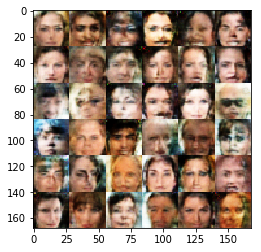

Epoch: 1, Batch: 2925: Discr train loss: 1.467, Gen train loss: 0.584
Epoch: 1, Batch: 2950: Discr train loss: 1.353, Gen train loss: 0.937
Epoch: 1, Batch: 2975: Discr train loss: 1.214, Gen train loss: 0.621
Epoch: 1, Batch: 3000: Discr train loss: 0.978, Gen train loss: 0.891


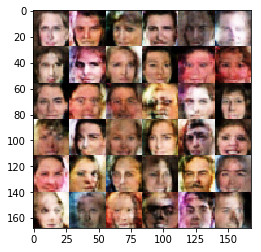

Epoch: 1, Batch: 3025: Discr train loss: 1.332, Gen train loss: 0.510
Epoch: 1, Batch: 3050: Discr train loss: 1.555, Gen train loss: 0.360
Epoch: 1, Batch: 3075: Discr train loss: 1.337, Gen train loss: 0.534
Epoch: 1, Batch: 3100: Discr train loss: 0.769, Gen train loss: 1.183


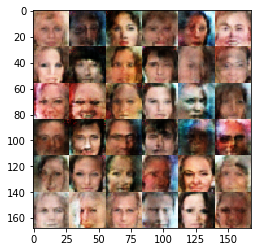

Epoch: 1, Batch: 3125: Discr train loss: 1.591, Gen train loss: 0.397
Epoch: 1, Batch: 3150: Discr train loss: 1.080, Gen train loss: 0.927
Epoch: 1, Batch: 3175: Discr train loss: 1.316, Gen train loss: 1.225
Epoch: 1, Batch: 3200: Discr train loss: 1.699, Gen train loss: 2.195


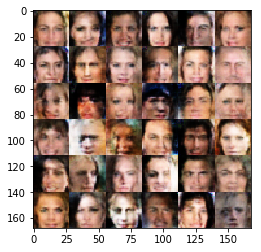

Epoch: 1, Batch: 3225: Discr train loss: 1.214, Gen train loss: 0.589
Epoch: 1, Batch: 3250: Discr train loss: 1.161, Gen train loss: 1.193
Epoch: 1, Batch: 3275: Discr train loss: 1.430, Gen train loss: 0.861
Epoch: 1, Batch: 3300: Discr train loss: 1.483, Gen train loss: 0.499


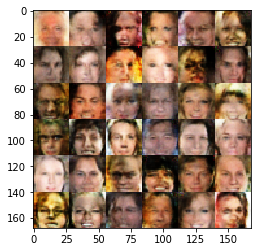

Epoch: 1, Batch: 3325: Discr train loss: 1.312, Gen train loss: 1.428
Epoch: 1, Batch: 3350: Discr train loss: 0.915, Gen train loss: 1.196
Epoch: 1, Batch: 3375: Discr train loss: 1.211, Gen train loss: 0.642
Epoch: 1, Batch: 3400: Discr train loss: 0.778, Gen train loss: 1.499


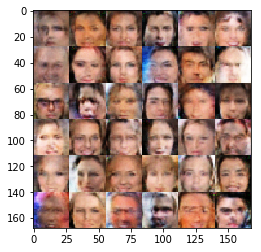

Epoch: 1, Batch: 3425: Discr train loss: 1.252, Gen train loss: 0.760
Epoch: 1, Batch: 3450: Discr train loss: 1.520, Gen train loss: 2.129
Epoch: 1, Batch: 3475: Discr train loss: 1.065, Gen train loss: 0.735
Epoch: 1, Batch: 3500: Discr train loss: 1.704, Gen train loss: 0.356


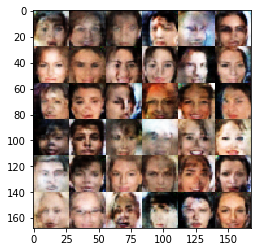

Epoch: 1, Batch: 3525: Discr train loss: 1.267, Gen train loss: 0.607
Epoch: 1, Batch: 3550: Discr train loss: 1.423, Gen train loss: 0.418
Epoch: 1, Batch: 3575: Discr train loss: 0.930, Gen train loss: 1.038
Epoch: 1, Batch: 3600: Discr train loss: 1.599, Gen train loss: 1.244


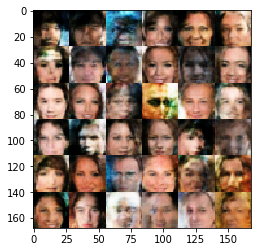

Epoch: 1, Batch: 3625: Discr train loss: 1.233, Gen train loss: 0.989
Epoch: 1, Batch: 3650: Discr train loss: 0.943, Gen train loss: 0.874
Epoch: 1, Batch: 3675: Discr train loss: 1.454, Gen train loss: 0.433
Epoch: 1, Batch: 3700: Discr train loss: 1.099, Gen train loss: 0.733


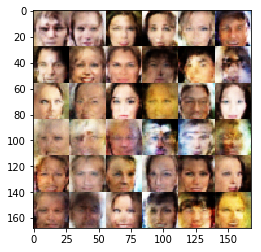

Epoch: 1, Batch: 3725: Discr train loss: 1.221, Gen train loss: 1.226
Epoch: 1, Batch: 3750: Discr train loss: 0.990, Gen train loss: 1.027
Epoch: 1, Batch: 3775: Discr train loss: 1.384, Gen train loss: 0.478
Epoch: 1, Batch: 3800: Discr train loss: 1.479, Gen train loss: 0.461


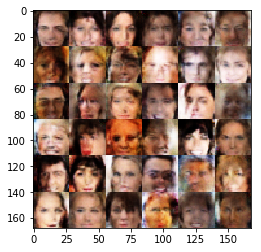

Epoch: 1, Batch: 3825: Discr train loss: 1.219, Gen train loss: 0.647
Epoch: 1, Batch: 3850: Discr train loss: 1.058, Gen train loss: 0.824
Epoch: 1, Batch: 3875: Discr train loss: 1.320, Gen train loss: 0.611
Epoch: 1, Batch: 3900: Discr train loss: 0.830, Gen train loss: 1.557


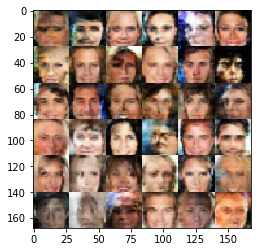

Epoch: 1, Batch: 3925: Discr train loss: 1.212, Gen train loss: 0.764
Epoch: 1, Batch: 3950: Discr train loss: 1.022, Gen train loss: 0.775
Epoch: 1, Batch: 3975: Discr train loss: 0.901, Gen train loss: 1.460
Epoch: 1, Batch: 4000: Discr train loss: 1.077, Gen train loss: 0.913


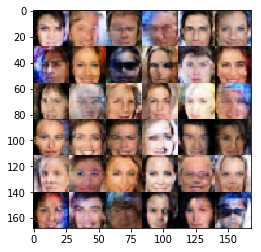

Epoch: 1, Batch: 4025: Discr train loss: 0.973, Gen train loss: 0.876
Epoch: 1, Batch: 4050: Discr train loss: 1.016, Gen train loss: 1.866
Epoch: 1, Batch: 4075: Discr train loss: 0.945, Gen train loss: 1.196
Epoch: 1, Batch: 4100: Discr train loss: 1.157, Gen train loss: 0.862


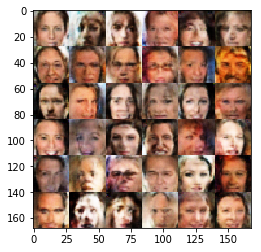

Epoch: 1, Batch: 4125: Discr train loss: 0.850, Gen train loss: 1.125
Epoch: 1, Batch: 4150: Discr train loss: 1.537, Gen train loss: 0.390
Epoch: 1, Batch: 4175: Discr train loss: 0.878, Gen train loss: 1.530
Epoch: 1, Batch: 4200: Discr train loss: 1.308, Gen train loss: 2.179


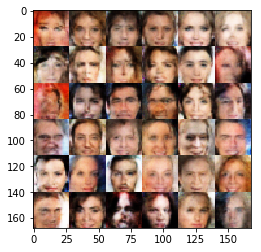

Epoch: 1, Batch: 4225: Discr train loss: 1.116, Gen train loss: 0.891
Epoch: 1, Batch: 4250: Discr train loss: 0.938, Gen train loss: 0.976
Epoch: 1, Batch: 4275: Discr train loss: 1.344, Gen train loss: 0.544
Epoch: 1, Batch: 4300: Discr train loss: 1.168, Gen train loss: 0.976


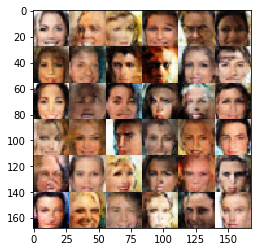

Epoch: 1, Batch: 4325: Discr train loss: 1.260, Gen train loss: 0.840
Epoch: 1, Batch: 4350: Discr train loss: 1.182, Gen train loss: 0.673
Epoch: 1, Batch: 4375: Discr train loss: 1.446, Gen train loss: 0.540
Epoch: 1, Batch: 4400: Discr train loss: 0.948, Gen train loss: 1.214


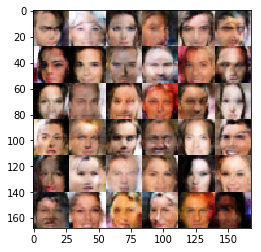

Epoch: 1, Batch: 4425: Discr train loss: 1.162, Gen train loss: 1.177
Epoch: 1, Batch: 4450: Discr train loss: 1.320, Gen train loss: 0.556
Epoch: 1, Batch: 4475: Discr train loss: 1.123, Gen train loss: 0.666
Epoch: 1, Batch: 4500: Discr train loss: 1.745, Gen train loss: 0.497


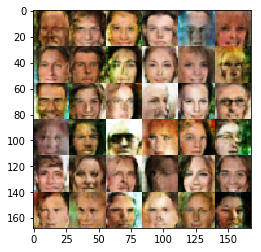

Epoch: 1, Batch: 4525: Discr train loss: 1.313, Gen train loss: 0.615
Epoch: 1, Batch: 4550: Discr train loss: 1.221, Gen train loss: 0.794
Epoch: 1, Batch: 4575: Discr train loss: 1.274, Gen train loss: 0.578
Epoch: 1, Batch: 4600: Discr train loss: 1.273, Gen train loss: 0.726


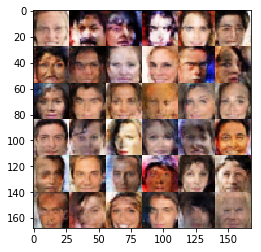

Epoch: 1, Batch: 4625: Discr train loss: 1.710, Gen train loss: 0.342
Epoch: 1, Batch: 4650: Discr train loss: 1.252, Gen train loss: 0.655
Epoch: 1, Batch: 4675: Discr train loss: 1.068, Gen train loss: 0.756
Epoch: 1, Batch: 4700: Discr train loss: 0.993, Gen train loss: 1.012


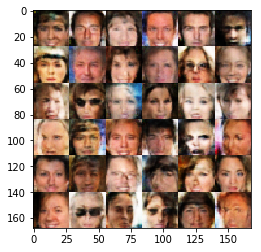

Epoch: 1, Batch: 4725: Discr train loss: 1.229, Gen train loss: 0.768
Epoch: 1, Batch: 4750: Discr train loss: 1.157, Gen train loss: 1.178
Epoch: 1, Batch: 4775: Discr train loss: 1.187, Gen train loss: 0.801
Epoch: 1, Batch: 4800: Discr train loss: 1.991, Gen train loss: 0.229


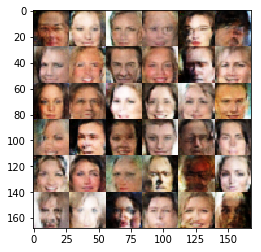

Epoch: 1, Batch: 4825: Discr train loss: 1.187, Gen train loss: 0.779
Epoch: 1, Batch: 4850: Discr train loss: 1.223, Gen train loss: 0.618
Epoch: 1, Batch: 4875: Discr train loss: 1.039, Gen train loss: 0.847
Epoch: 1, Batch: 4900: Discr train loss: 0.887, Gen train loss: 1.636


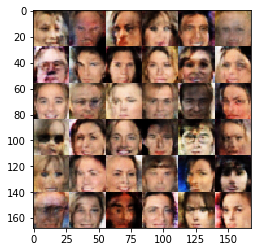

Epoch: 1, Batch: 4925: Discr train loss: 1.239, Gen train loss: 0.558
Epoch: 1, Batch: 4950: Discr train loss: 1.383, Gen train loss: 0.562
Epoch: 1, Batch: 4975: Discr train loss: 1.265, Gen train loss: 0.647
Epoch: 1, Batch: 5000: Discr train loss: 1.251, Gen train loss: 0.656


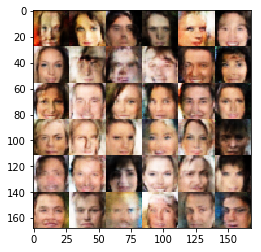

Epoch: 1, Batch: 5025: Discr train loss: 1.098, Gen train loss: 1.055
Epoch: 1, Batch: 5050: Discr train loss: 0.865, Gen train loss: 1.396
Epoch: 1, Batch: 5075: Discr train loss: 0.974, Gen train loss: 1.030
Epoch: 1, Batch: 5100: Discr train loss: 1.096, Gen train loss: 1.003


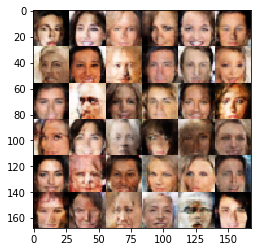

Epoch: 1, Batch: 5125: Discr train loss: 1.286, Gen train loss: 0.690
Epoch: 1, Batch: 5150: Discr train loss: 1.380, Gen train loss: 0.540
Epoch: 1, Batch: 5175: Discr train loss: 1.050, Gen train loss: 0.848
Epoch: 1, Batch: 5200: Discr train loss: 1.312, Gen train loss: 0.724


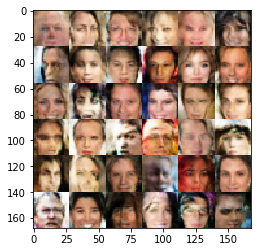

Epoch: 1, Batch: 5225: Discr train loss: 1.142, Gen train loss: 0.812
Epoch: 1, Batch: 5250: Discr train loss: 1.421, Gen train loss: 0.464
Epoch: 1, Batch: 5275: Discr train loss: 1.355, Gen train loss: 0.482
Epoch: 1, Batch: 5300: Discr train loss: 0.979, Gen train loss: 1.114


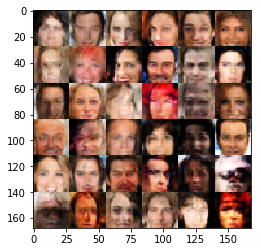

Epoch: 1, Batch: 5325: Discr train loss: 1.208, Gen train loss: 0.973
Epoch: 1, Batch: 5350: Discr train loss: 1.295, Gen train loss: 0.593
Epoch: 1, Batch: 5375: Discr train loss: 1.221, Gen train loss: 0.674
Epoch: 1, Batch: 5400: Discr train loss: 0.933, Gen train loss: 0.933


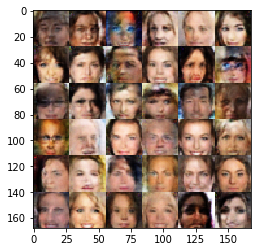

Epoch: 1, Batch: 5425: Discr train loss: 1.201, Gen train loss: 0.726
Epoch: 1, Batch: 5450: Discr train loss: 1.433, Gen train loss: 0.389
Epoch: 1, Batch: 5475: Discr train loss: 0.985, Gen train loss: 1.231
Epoch: 1, Batch: 5500: Discr train loss: 1.452, Gen train loss: 0.484


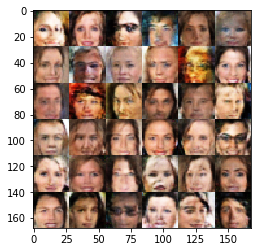

Epoch: 1, Batch: 5525: Discr train loss: 1.117, Gen train loss: 0.816
Epoch: 1, Batch: 5550: Discr train loss: 1.060, Gen train loss: 1.161
Epoch: 1, Batch: 5575: Discr train loss: 1.304, Gen train loss: 0.564
Epoch: 1, Batch: 5600: Discr train loss: 1.215, Gen train loss: 0.877


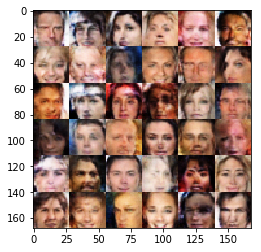

Epoch: 1, Batch: 5625: Discr train loss: 1.254, Gen train loss: 0.601
Epoch: 1, Batch: 5650: Discr train loss: 1.203, Gen train loss: 1.166
Epoch: 1, Batch: 5675: Discr train loss: 1.020, Gen train loss: 0.961
Epoch: 1, Batch: 5700: Discr train loss: 1.343, Gen train loss: 0.588


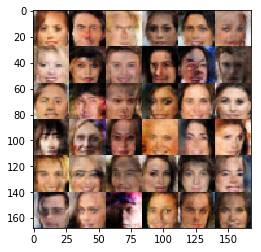

Epoch: 1, Batch: 5725: Discr train loss: 1.321, Gen train loss: 0.653
Epoch: 1, Batch: 5750: Discr train loss: 1.300, Gen train loss: 0.580
Epoch: 1, Batch: 5775: Discr train loss: 1.846, Gen train loss: 0.266
Epoch: 1, Batch: 5800: Discr train loss: 1.325, Gen train loss: 0.585


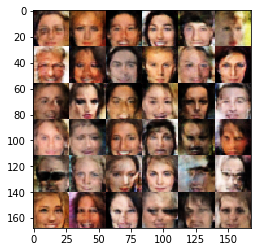

Epoch: 1, Batch: 5825: Discr train loss: 1.489, Gen train loss: 0.443
Epoch: 1, Batch: 5850: Discr train loss: 1.016, Gen train loss: 0.969
Epoch: 1, Batch: 5875: Discr train loss: 1.164, Gen train loss: 0.838
Epoch: 1, Batch: 5900: Discr train loss: 1.134, Gen train loss: 0.850


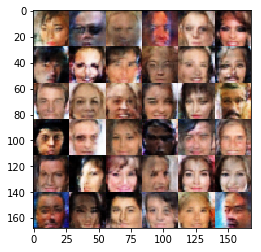

Epoch: 1, Batch: 5925: Discr train loss: 1.330, Gen train loss: 0.715
Epoch: 1, Batch: 5950: Discr train loss: 1.031, Gen train loss: 1.354
Epoch: 1, Batch: 5975: Discr train loss: 1.262, Gen train loss: 0.543
Epoch: 1, Batch: 6000: Discr train loss: 0.989, Gen train loss: 1.102


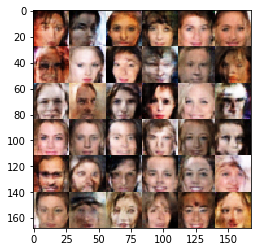

Epoch: 1, Batch: 6025: Discr train loss: 1.185, Gen train loss: 0.569
Epoch: 1, Batch: 6050: Discr train loss: 1.618, Gen train loss: 0.442
Epoch: 1, Batch: 6075: Discr train loss: 1.583, Gen train loss: 0.537
Epoch: 1, Batch: 6100: Discr train loss: 1.321, Gen train loss: 0.815


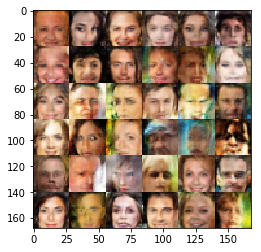

Epoch: 1, Batch: 6125: Discr train loss: 1.076, Gen train loss: 1.078
Epoch: 1, Batch: 6150: Discr train loss: 1.525, Gen train loss: 0.375
Epoch: 1, Batch: 6175: Discr train loss: 1.372, Gen train loss: 0.546
Epoch: 1, Batch: 6200: Discr train loss: 1.278, Gen train loss: 0.803


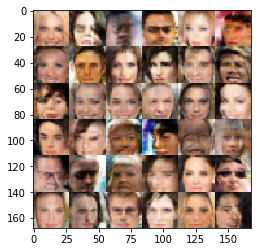

Epoch: 1, Batch: 6225: Discr train loss: 1.366, Gen train loss: 0.490
Epoch: 1, Batch: 6250: Discr train loss: 1.017, Gen train loss: 0.906
Epoch: 1, Batch: 6275: Discr train loss: 0.994, Gen train loss: 0.817
Epoch: 1, Batch: 6300: Discr train loss: 1.282, Gen train loss: 0.666


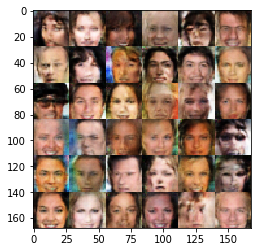

Epoch: 1, Batch: 6325: Discr train loss: 1.363, Gen train loss: 1.175


In [18]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.